## Simulating Chaotic Rayleigh-Benard Convection in Firedrake

This problem involves a variable-temperature incompressible fluid. Variations in the fluid temperature are assumed to affect the momentum balance through a buoyant term (the Boussinesq approximation), leading to a Navier-Stokes equation with a nonlinear coupling to a convection-diffusion equation for temperature.

We will set up the problem using Taylor-Hood elements for the Navier-Stokes part, and piecewise linear elements for the temperature.

\begin{align} 
\Delta u + u \cdot \nabla u + \nabla p + \frac{Ra}{Pr} T =  0 \\
\nabla \cdot u = 0 \\
-\frac{1}{Pr} \Delta T + u \cdot \nabla T = 0
\end{align}

In [3]:
from firedrake import *
from firedrake.petsc import PETSc
import matplotlib.pyplot as plt


## Meshes

While this mesh is not fine enough to produce a meaningful simulation, the image it produces shows the structure of the mesh along with the borders and their associated numbers (this will come in handy when creating boundary conditions).

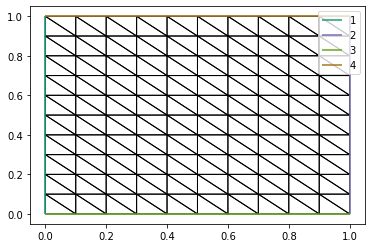

In [4]:
N = 10
mesh = UnitSquareMesh(N, N)
fig, axes = plt.subplots()
triplot(mesh, axes=axes)
axes.legend();

Our true mesh will be 128x128 cells.

In [5]:
N = 128
mesh = UnitSquareMesh(N, N)

In [6]:
#polynomial degree of the pressure space
degree = 1

V = VectorFunctionSpace(mesh, "CG", degree + 1)
V_out = VectorFunctionSpace(mesh, "CG", degree)
P = FunctionSpace(mesh, "CG", degree)
T = FunctionSpace(mesh, "CG", degree)
Z = V * P * T

upT = Function(Z, name="current")
upT_ = Function(Z, name="next")
u, p, Temp = split(upT)
v, q, S = TestFunctions(Z)

# Two key physical parameters are the Rayleigh number (Ra), which
# measures the ratio of energy from buoyant forces to viscous
# dissipation and heat conduction and the
# Prandtl number (Pr), which measures the ratio of viscosity to heat
# conduction. ::

Ra = Constant(2e4)
Pr = Constant(6.8)

# Along with gravity, which points down. ::

g = Constant((0, -1))

F = (
    inner(grad(u), grad(v))*dx
    + inner(dot(grad(u), u), v)*dx
    - inner(p, div(v))*dx
    - (Ra/Pr)*inner(Temp*g, v)*dx
    + inner(div(u), q)*dx
    + inner(dot(grad(Temp), u), S)*dx
    + 1/Pr * inner(grad(Temp), grad(S))*dx
)


bcs = [
    DirichletBC(Z.sub(0), Constant((0, 0)), (1, 2, 3, 4)),
    DirichletBC(Z.sub(2), Constant(1.0), (3,)),
    DirichletBC(Z.sub(2), Constant(0.0), (4,))
]


nullspace = MixedVectorSpaceBasis(
    Z, [Z.sub(0), VectorSpaceBasis(constant=True), Z.sub(2)])


In [7]:
parameters1 = {"mat_type": "matfree",
              "snes_monitor": None,
              "ksp_type": "gmres",
              "pc_type": "fieldsplit",
              "pc_fieldsplit_type": "multiplicative",

# We want to split the Navier-Stokes part off from the temperature
# variable. ::

              "pc_fieldsplit_0_fields": "0,1",
              "pc_fieldsplit_1_fields": "2",

# We'll invert the Navier-Stokes block with MUMPS::

              "fieldsplit_0_ksp_type": "preonly",
              "fieldsplit_0_pc_type": "python",
              "fieldsplit_0_pc_python_type": "firedrake.AssembledPC",
              "fieldsplit_0_assembled_pc_type": "lu",
              "fieldsplit_0_assembled_pc_factor_mat_solver_type": "mumps",

# the temperature block will also be inverted directly, but with plain
# LU.::

              "fieldsplit_1_ksp_type": "preonly",
              "fieldsplit_1_pc_type": "python",
              "fieldsplit_1_pc_python_type": "firedrake.AssembledPC",
              "fieldsplit_1_assembled_pc_type": "lu"}

parameters2 = {"mat_type": "matfree",
              "snes_monitor": None,

# We'll use inexact GMRES solves to invert the Navier-Stokes block, so
# the preconditioner as a whole is not stationary, hence we need
# flexible GMRES. ::

             "ksp_type": "fgmres",
             "ksp_gmres_modifiedgramschmidt": True,
             "pc_type": "fieldsplit",
             "pc_fieldsplit_type": "multiplicative",

# Again we split off Navier-Stokes from the temperature block ::

             "pc_fieldsplit_0_fields": "0,1",
             "pc_fieldsplit_1_fields": "2",

# which we solve inexactly using preconditioned GMRES. ::

             "fieldsplit_0": {
                 "ksp_type": "gmres",
                 "ksp_gmres_modifiedgramschmidt": True,
                 "ksp_rtol": 1e-2,
                 "pc_type": "fieldsplit",
                 "pc_fieldsplit_type": "schur",
                 "pc_fieldsplit_schur_fact_type": "lower",

# Invert the velocity block with a single V-cycle of algebraic
# multigrid::

                 "fieldsplit_0": {
                     "ksp_type": "preonly",
                     "pc_type": "python",
                     "pc_python_type": "firedrake.AssembledPC",
                     "assembled_pc_type": "hypre"
                 },

# and approximate the Schur complement inverse with PCD. ::

                 "fieldsplit_1": {
                      "ksp_type": "preonly",
                      "pc_type": "python",
                      "pc_python_type": "firedrake.PCDPC",

# We need to configure the pressure mass and Poisson solves, along with
# how to apply the convection-diffusion operator.  For the latter, we
# will use an assembled operator this time round. ::

                      "pcd_Mp_ksp_type": "preonly",
                      "pcd_Mp_pc_type": "ilu",
                      "pcd_Kp_ksp_type": "preonly",
                      "pcd_Kp_pc_type": "hypre",
                      "pcd_Fp_mat_type": "aij"
                 }
             },

# Now for the temperature block, we use a moderately coarse tolerance
# for algebraic multigrid preconditioned GMRES. ::

            "fieldsplit_1": {
                 "ksp_type": "gmres",
                 "ksp_rtol": "1e-4",
                 "pc_type": "python",
                 "pc_python_type": "firedrake.AssembledPC",
                 "assembled_pc_type": "hypre"
            }
       }



In [8]:
# First off, we'll solve the full system using a direct solver.  As
# previously, we use MUMPS, so wrap the solve in ``try/except`` to avoid
# errors if it is not available. ::
solve(F == 0, upT, bcs=bcs, nullspace=nullspace,
      solver_parameters={"mat_type": "aij",
                        "snes_monitor": None,
                        "ksp_type": "gmres",
                        "pc_type": "lu",
                        "pc_factor_mat_solver_type": "mumps"})

upT.assign(0)
solve(F == 0, upT, bcs=bcs, nullspace=nullspace,
      solver_parameters=parameters1)



In [12]:
appctx = {"velocity_space": 0}
upT.assign(0)
u, p, Temp = upT.split()

#outfile = File("test.pvd")
#outfile.write(project(u, V_out, name="Velocity"))


upT_.assign(0)
t = 0.0
end = 1
timestep = .25

results = [project(u, V_out, name="Velocity")]
while (t <= end):
    t += timestep
    
    solve(F == 0, upT, bcs=bcs, nullspace=nullspace,
          solver_parameters=parameters2, appctx=appctx)
    upT_.assign(upT)
    u, p, Temp = upT.split()
    results.append(project(u, V_out, name="Velocity"))
    #outfile.write(project(u, V_out, name="Velocity"))



In [20]:
from matplotlib.animation import FuncAnimation

def animate(u):
    axes.clear()
    axes.set_aspect("equal")
    contours = tricontourf(u,  axes=axes, cmap="inferno")
    
    
interval = 4e3 * float(timestep)
animation = FuncAnimation(fig, animate, frames=results, interval=interval)

from IPython.display import HTML
HTML(animation.to_jshtml())